# Predicting Movie Earnings
    Thomas van der Molen
    S4-AI41

## Table of Contents
- [Version History](#Version-History)
- [Domain Understanding](#Domain-Understanding)  
  * [Introduction](#Introduction)
  * [Problem Statement](#Problem-Statement)
  * [Target Audience](#Target-Audience)
  * [Expert Domain Clarification](#Expert-Domain-Clarification)
- [Data Sourcing](#Data-Sourcing)
  * [Exploratory Data Analysis](#Exploratory-Data-Analysis)
  * [Target Value](#Target-Value)
  * [Disclaimer](#Disclaimer)
- [Analytic Approach](#Analytic-Approach)
  * [Nearest Neighbor](#Nearest-Neighbor)
    * [Discussion](#Discussion)
  * [Linear Regression](#Linear-Regression)
    * [Correlation Mapping](#Correlation-Mapping)
    * [Ransac](#Ransac)
- [Evaluation](#Evaluation)

In [264]:
%%html
<style>
table {float:left}
img {float:left}
</style>

## Version History
| Version | Date | Change |
| :---: | :--- | :--- |
| 1.0 | 17-02-2022 | Created document |
| 1.1 | 18-02-2022 | Started work on the introduction |
| 1.2 | 25-02-2022 | Added more structure based on SI lecture |
| 1.3 | 07-03-2022 | Converted document to markdown |
| 1.4 | 09-03-2022 | Worked on Exploratory Data Analysis |
| 1.5 | 10-03-2022 | Wroked on Analytic Approach |
| 1.6 | 11-03-2022 | Finished writing first full iteration of proposal |

# Domain Understanding

### Introduction
As someone who enjoys watching movies, there often seems to be a polarizing difference between what movies perform well and which ones do not. With movies being [a billion-dollar industry](https://www.boxofficepro.com/mpa-2019-global-box-office-and-home-entertainment-surpasses-100-billion/), there seems to be a lot of risk and reward involved when investing and making movies. 
  
I am interested in finding possible patterns to predict how much a movie will earn in the box office compared to the amount of money spent on budget. This could give movie companies a clearer vision of how much they should spend for the best result, reducing the amount of risk taken when investing in movies with budgets of [100 million+ dollars](https://www.the-numbers.com/movie/budgets/all).

### Problem Statement
For this project I Will be trying to predict:  
*How much will a movie earn based on publicly available data.*

### Target Audience
There are a lot of different parties involved during the process of making a movie, for this reason there are many different groups that could benefit from the given predictions.  
  
The most obvious ones are the production and distribution companies such as:  
[Paramount Pictures Studios](http://www.paramountstudios.com/), [Warner Bros. Pictures](https://www.warnerbros.com/company/divisions/motion-pictures), [Sony Pictures](https://www.sonypictures.com/), [Lionsgate](https://www.lionsgate.com/), etc.  
  
Further from the actual production and distribution process are companies such as [Peacock Film Finance](https://peacockfilmfinance.com/), who as the name suggests help finance the production of movies.  
  
Besides these you could also include Bond companies, these companies are a form of insurance agency such as [Surety Bonds Direct](https://www.suretybondsdirect.com/).  
  
I am going to focus my domain on the production companies, because these are the companies that take large risks when setting the budget and producing a movie, and could use this prediction to get investments and get more people interested in their movie.

### Expert Domain Clarification
I have tried reaching out to several (smaller) movie production companies to try and get an interview with them such as [24fps productions](https://www.24fpsproductions.com/).\
Sadly, there has been no responses to my requests.

## Data Sourcing
One of the other reasons I chose to try and work with movies, is because movies seem to have a lot of public data attached to them for example, most movies share their box office revenue ([or are tracked by third parties](https://movies.stackexchange.com/questions/27777/why-are-box-office-numbers-made-public)) and in most cases movie budgets will also be provided. Other than this information such as the cast, genre, runtime, release date and critic scores are also widely available.  
  
For sourcing data there are a few well known sources to get large amounts of data from movies, such as [IMDb](https://www.imdb.com/), [TMDB](https://www.themoviedb.org/) and [Rotten Tomatoes](https://www.rottentomatoes.com/).

For my first iteration I have created a bot to go through the supplied API from TMDB and get all surface level information available.  
  
This system has been made in C# and can be found [here in my repository](https://github.com/Thomas-Molen/FHICT-S4-AI/tree/main/Challenge/TMDBScraper/TMDBScraper)

### Exploratory Data Analysis

As explained in the part [Data Sourcing](#Data-Sourcing), I have created my own C# bot that for my original proposal consumes the TMDB API to fetch all movies in their database, this database contains a lot of useful data but for this original iteration I will be focusing on only a couple of these features.

In [265]:
import pandas as pd
import numpy as np

print('numpy version:', np.__version__)
print('matplotlib version:', pd.__version__)

numpy version: 1.20.3
matplotlib version: 1.3.4


Info on full original dataset:  
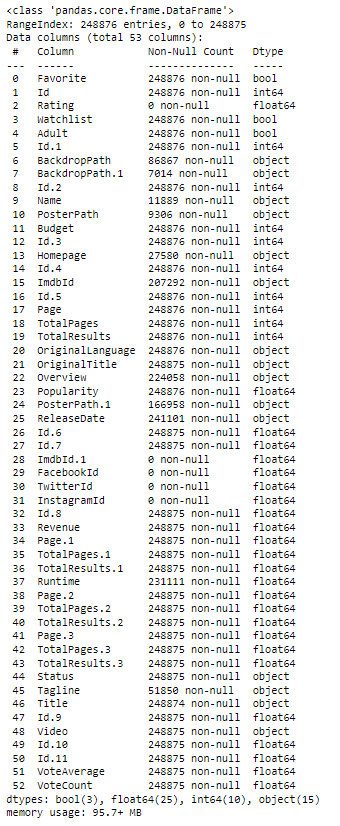

A lot of the given columns are fairly useless as features to use for predicting, these include rows such as the Id.x columns because these are only used internally for referencing and columns such as backdroppath which contains a link to an image, which is of very little use.

Load the data and filter out all unnecessary columns.

In [266]:
cols = ['OriginalLanguage', 'Budget', 'Popularity', 'ReleaseDate', 'Revenue', 'Title', 'Adult', 'Name', 'Status', 'Runtime', 'VoteAverage']
df = pd.read_csv('movies.csv', usecols=cols)

In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248876 entries, 0 to 248875
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Adult             248876 non-null  bool   
 1   Name              11889 non-null   object 
 2   Budget            248876 non-null  int64  
 3   OriginalLanguage  248876 non-null  object 
 4   Popularity        248876 non-null  float64
 5   ReleaseDate       241101 non-null  object 
 6   Revenue           248875 non-null  float64
 7   Runtime           231111 non-null  float64
 8   Status            248875 non-null  object 
 9   Title             248874 non-null  object 
 10  VoteAverage       248875 non-null  float64
dtypes: bool(1), float64(4), int64(1), object(5)
memory usage: 19.2+ MB


When observing the dataset in excel, there seem to be broken entries, such as here you can see record 254902 that seems to have it's values moved around. However when looking at it via pandas it is not.  
This shows that Excel does not handle this csv data well all the time (from what it misread ~300 out of ~250000 records).

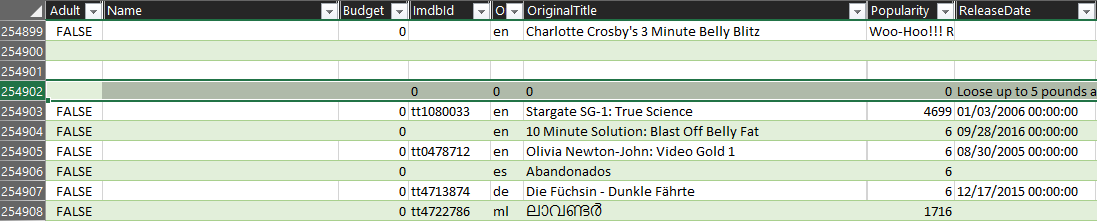

In [268]:
df.tail(7)

,Adult,Name,Budget,OriginalLanguage,Popularity,ReleaseDate,Revenue,Runtime,Status,Title,VoteAverage
248869,False,NaN,0,en,0.600,12/26/2014 00:00:00,0.0,65.0,Released,Charlotte Crosby's 3 Minute Belly Blitz,5.0
248870,False,NaN,0,en,4.699,01/03/2006 00:00:00,0.0,45.0,Released,Stargate SG-1: True Science,7.8
248871,False,NaN,0,en,0.600,09/28/2016 00:00:00,0.0,55.0,Released,10 Minute Solution: Blast Off Belly Fat,0.0
248872,False,NaN,0,en,0.600,08/30/2005 00:00:00,0.0,69.0,Released,Olivia Newton-John: Video Gold 1,6.8
248873,False,NaN,0,es,0.600,NaN,0.0,0.0,Released,Abandonados,8.0
248874,False,NaN,0,de,0.600,12/17/2015 00:00:00,0.0,85.0,Released,Die Füchsin - Dunkle Fährte,4.0
248875,False,NaN,0,ml,1.716,NaN,NaN,NaN,NaN,NaN,NaN


Look into Missing data

In [269]:
df.isna().sum()

Adult                    0
Name                236987
Budget                   0
OriginalLanguage         0
Popularity               0
ReleaseDate           7775
Revenue                  1
Runtime              17765
Status                   1
Title                    2
VoteAverage              1
dtype: int64

Firstly I will tidy up the data such as remove all Unreleased movies as these will not have any useful impact when predicting how a movie will perform after release

In [270]:
movies = df.drop(df[df.Status != 'Released'].index)
print('Unreleased movies removed:', (len(df.index) - len(movies.index)))

Unreleased movies removed: 393


Create an easily readable boolean column for if the movie is part of a franchise/series

In [271]:
movies['Franchise'] = movies['Name'].map( {np.NAN: 0} ).fillna(1).astype(bool)
# movies.head()
movies.sort_values('Revenue', ascending=False)

,Adult,Name,Budget,OriginalLanguage,Popularity,ReleaseDate,Revenue,Runtime,Status,Title,VoteAverage,Franchise
12076,False,Avatar Collection,237000000,en,400.157,12/10/2009 00:00:00,2.847246e+09,162.0,Released,Avatar,7.5,True
184412,False,The Avengers Collection,356000000,en,250.597,04/24/2019 00:00:00,2.797801e+09,181.0,Released,Avengers: Endgame,8.3,True
476,False,NaN,200000000,en,152.365,11/18/1997 00:00:00,2.187464e+09,194.0,Released,Titanic,7.9,False
89373,False,Star Wars Collection,245000000,en,93.786,12/15/2015 00:00:00,2.068224e+09,136.0,Released,Star Wars: The Force Awakens,7.3,True
184414,False,The Avengers Collection,300000000,en,414.809,04/25/2018 00:00:00,2.046240e+09,149.0,Released,Avengers: Infinity War,8.3,True
...,...,...,...,...,...,...,...,...,...,...,...,...
88487,False,NaN,0,en,0.600,11/18/2016 00:00:00,0.000000e+00,0.0,Released,R.E.M. - Out Of Time,10.0,False
88488,False,NaN,0,ko,2.049,08/08/2012 00:00:00,0.000000e+00,120.0,Released,I Am The King,6.7,False
88489,False,NaN,0,de,1.280,11/15/2012 00:00:00,0.000000e+00,77.0,Released,Heavy Girls,4.6,False
248874,False,NaN,0,de,0.600,12/17/2015 00:00:00,0.000000e+00,85.0,Released,Die Füchsin - Dunkle Fährte,4.0,False


Set all 0 values to null for easier analysis

In [272]:
movies[['Budget', 'Revenue', 'Popularity', 'VoteAverage', 'Runtime']] = movies[['Budget', 'Revenue', 'Popularity', 'VoteAverage', 'Runtime']].replace(0, np.NAN)

Convert releasedate into quarters, this will make it easier to categorize movies based releasedate.
I could also categorize per year, but this will not give any useful information seen as new movies will always be in the most recent year, effectively making all previous years useless.  
  
I have also tried splitting the dates up per month but this had no effect compared to quarterly, so for this iteration I will be sticking with quarterly splitting.

In [273]:
movies['ReleaseDate'] = movies['ReleaseDate'].astype('datetime64')
# movies['Quarter'] = movies['ReleaseDate'].map(lambda x: x.month)
movies['Quarter'] = movies['ReleaseDate'].dt.quarter
# movies['Q1'] = movieQuarter.map( {1: 1 } ).fillna(0).astype(bool)
# movies['Q2'] = movieQuarter.map( {2: 1 } ).fillna(0).astype(bool)
# movies['Q3'] = movieQuarter.map( {3: 1 } ).fillna(0).astype(bool)
# movies['Q4'] = movieQuarter.map( {4: 1 } ).fillna(0).astype(bool)
movies.head()

,Adult,Name,Budget,OriginalLanguage,Popularity,ReleaseDate,Revenue,Runtime,Status,Title,VoteAverage,Franchise,Quarter
0,False,Blondie Collection,NaN,en,1.879,1938-11-30,NaN,70.0,Released,Blondie,7.1,True,4.0
1,False,NaN,NaN,de,0.726,1921-01-01,NaN,420.0,Released,"Peter Voss, Thief of Millions",NaN,False,1.0
2,False,NaN,NaN,fr,2.544,1962-06-22,NaN,110.0,Released,Love at Twenty,6.8,False,2.0
3,False,New World Disorder,NaN,en,0.652,2008-12-08,NaN,69.0,Released,New World Disorder 9: Never Enough,4.5,True,4.0
4,False,NaN,NaN,en,0.923,2010-01-05,NaN,46.0,Released,Sesame Street: Elmo Loves You!,NaN,False,1.0


### Target Value

I think that revenue compared to profit will be a very useful feature when trying to predict the market success of a movie, I see that in my dataset of ~250000 there are 7717 datapoints for this potential feature.  
But the database I am acquiring the movies from should contain a little over double of this so the total amount of datapoints can become around 15000 with the complete dataset.  
  
I will have to consider if this is enough datapoints, or if i will have to enrich this with data from different datasets such as from [the-numbers.com](https://www.the-numbers.com/)

In [274]:
print('\nMovies with Budget & Revenue:', len(movies[(~movies['Budget'].isnull()) & (~movies['Revenue'].isnull())].index))


Movies with Budget & Revenue: 7717


After looking more at the dataset, specifically the datapoints with a low budget or revenue I realised that there are some datapoints containing wrong values, this will skew the data during modelling and therefore i think it would be good to remove these as they are not valid.  
  
after doing research into [realistic budget](https://en.wikipedia.org/wiki/Low-budget_film) and revenue I found that very low budgets for movies start from \\$1000 (and this is pretty generous most budgets are way higher than this).  
For revenue it will be harder to set a threshhold, but by observing the dataset I found that there are very little movies between \\$1000 - \\$10000 in revenue, for this reason it seems reasonable to assume that values under \\$1000 in revenue are invalid.

In [275]:
print('budget <= 1000:', len(movies[movies['Budget'] <= 1000]))
print('revenue <= 1000:', len(movies[movies['Revenue'] <= 1000]))

movies[movies[['Budget', 'Revenue']] <= 1000] = np.nan

budget <= 1000: 1233
revenue <= 1000: 364


I will now create a profit coefficient (PC = revenue/budget) to easily read how much revenue a movie made compared to their budget, this will be the target value because the higher this number to more successful a movie will be in it's simplest terms.

In [276]:
movies['PC'] = (movies['Revenue']/movies['Budget'])
movies[(~movies['Budget'].isnull()) & (~movies['Revenue'].isnull())].head()

,Adult,Name,Budget,OriginalLanguage,Popularity,ReleaseDate,Revenue,Runtime,Status,Title,VoteAverage,Franchise,Quarter,PC
7,False,NaN,4000000.0,en,16.897,1995-12-09,4257354.0,98.0,Released,Four Rooms,5.7,False,4.0,1.064339
8,False,NaN,21000000.0,en,10.801,1993-10-15,12136938.0,110.0,Released,Judgment Night,6.5,False,4.0,0.577949
11,False,Star Wars Collection,11000000.0,en,96.633,1977-05-25,775398007.0,121.0,Released,Star Wars,8.2,True,2.0,70.490728
12,False,Finding Nemo Collection,94000000.0,en,125.016,2003-05-30,940335536.0,100.0,Released,Finding Nemo,7.8,True,2.0,10.003570
13,False,NaN,55000000.0,en,74.714,1994-07-06,677387716.0,142.0,Released,Forrest Gump,8.5,False,3.0,12.316140


Now that the data has been tidied up I can have a clearer look of what data I am actually working with

In [277]:
movies = movies[['Adult', 'Budget', 'OriginalLanguage', 'Popularity', 'Quarter', 'PC', 'Title', 'Franchise', 'Revenue', 'VoteAverage', 'Runtime']]
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248483 entries, 0 to 248874
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Adult             248483 non-null  bool   
 1   Budget            15187 non-null   float64
 2   OriginalLanguage  248483 non-null  object 
 3   Popularity        248483 non-null  float64
 4   Quarter           241087 non-null  float64
 5   PC                7532 non-null    float64
 6   Title             248482 non-null  object 
 7   Franchise         248483 non-null  bool   
 8   Revenue           10944 non-null   float64
 9   VoteAverage       165568 non-null  float64
 10  Runtime           199038 non-null  float64
dtypes: bool(2), float64(7), object(2)
memory usage: 19.4+ MB


In [278]:
print('\nMovies with Profit coefficient:', len(movies[~movies['PC'].isnull()].index))


Movies with Profit coefficient: 7532


This dataframe gives me 7500 datapoints to work with, and has clear potential with multiple features such as if the movie is adult rated, the original language, popularity (based on the TMDB website), if the movie is part of a franchise and which quarter it was released.

### Disclaimer

After working on the Analytic Approach, I noticed that using PC as the target is not a smart idea because correlation will be lost when comparing features. Besides while discussing this point with the machinelearning teacher, there is very little reason to use PC over using revenue as my target value, using PC only obscures the real prediction that I want and for using it as a KPI revenue can always be calculated into PC.

## Analytic Approach

Firstly I will visualize my chosen features to see possible correlation

In [279]:
import sklearn as sk

print('scikit-learn version:', sk.__version__)

scikit-learn version: 1.0.2


### Nearest Neighbor
As explained in the [Discussion](#Discussion) using nearest neighbor is a terrible idea, if you want to see the model actually used go to [Linear Regression](#Linear-Regression)

Create different classes for unsuccessful, neutral and successful based on PC

In [280]:
from sklearn.model_selection import train_test_split

# Remove NANs from the target
NNMovies = movies.drop(movies[movies.PC.isnull()].index)

# Function to return success values based on value range
def mapSuccess(PC):
   if PC <= 0.75: 
        return 'unsuccessful'
   elif 0.75< PC <=1.25: 
        return 'neutral'
   elif PC > 1.25: 
        return 'successful'
   else:
        return np.NAN

# def mapSuccess(PC):
#    if PC <= 1: 
#         return 'unsuccessful'
#    elif PC > 1: 
#         return 'successful'
#    else:
#         return np.NAN

NNMovies['Success'] = NNMovies['PC'].apply(mapSuccess) 
NNMovies.head()

,Adult,Budget,OriginalLanguage,Popularity,Quarter,PC,Title,Franchise,Revenue,VoteAverage,Runtime,Success
7,False,4000000.0,en,16.897,4.0,1.064339,Four Rooms,False,4257354.0,5.7,98.0,neutral
8,False,21000000.0,en,10.801,4.0,0.577949,Judgment Night,False,12136938.0,6.5,110.0,unsuccessful
11,False,11000000.0,en,96.633,2.0,70.490728,Star Wars,True,775398007.0,8.2,121.0,successful
12,False,94000000.0,en,125.016,2.0,10.003570,Finding Nemo,True,940335536.0,7.8,100.0,successful
13,False,55000000.0,en,74.714,3.0,12.316140,Forrest Gump,False,677387716.0,8.5,142.0,successful


In [281]:
# Feature selection
# Remove all NANs from feature
NNMovies = NNMovies.drop(NNMovies[NNMovies.Quarter.isnull()].index)

X = NNMovies[['Budget', 'Popularity']]
print(len(NNMovies.index))
# print(len(NNMovies[NNMovies['Success'] == 'unsuccessful'].index))
NNMovies.isnull().sum()

7524


Adult                0
Budget               0
OriginalLanguage     0
Popularity           0
Quarter              0
PC                   0
Title                0
Franchise            0
Revenue              0
VoteAverage         58
Runtime             28
Success              0
dtype: int64

In [282]:
from sklearn.neighbors import KNeighborsClassifier

# Select target
y = NNMovies['Success']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Fitting model
clf = KNeighborsClassifier(5)
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [283]:
from sklearn import metrics

# Analyze model
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.6198830409356725

#### Discussion

Accuracy with different features, predicting successfulness of movies (unsuccessful, neutral, successful)
Single features:  
    Budget: 0.5540  
    Popularity: 0.5619  
    Quarter: 0.5348  
    Franchise: 0.6279

Double features:  
    Budget, Popularity: 0.6199  
    Budget, Quarter: 0.5556  
    Budget, Franchise: 0.5805  
    Popularity, Quarter: 0.5683  
    Popularity, Franchise: 0.5657  
    Quarter, Franchise: 0.5253  
  
Now lets see why certain features perform better than others.

In [284]:
from sklearn.metrics import classification_report

target_names = ['neutral', 'successful', 'unsuccessful']
# print(classification_report(y_test, y_pred, target_names=target_names, zero_division=True))

Budget:  
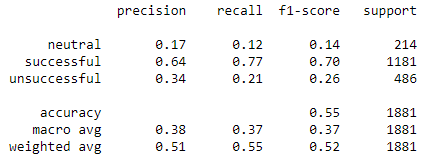  

Popularity:  
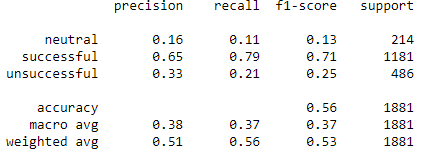

Franchise:  
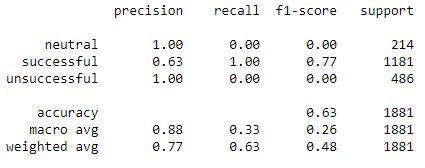

The first thing I noticed was that the Franchise feature on it's own got a better accuracy compared to the other features, but when combining with other features it actually does not create the most accuracte feature combination.  
The reason for this is clarified when looking at the recall and precision score for Franchise. In general movies get made into a franchise when they are highly successful, for this reason knowing if a movie is a franchise will make it a lot easier to predict that the movie is successful, while there is probably very few franchise movies that performed neutral or unsuccessful.      
  
In general there seems to be a big difference in accuracy between the successful movies and the other categories. However I am not sure if this is because there is a clear difference between successful movies and not, or if there is a lack of neutral and unsuccessful movies causing the model to not have enough datapoints for it.

After speaking with my machine learning teacher and discusing what I have done so far, I got the feedback that categorization is a really bad idea I already considered this but thought that using nearest neighbor for iteration zero would be a valuable tradeoff.  
  
However While talking to the machine learning teacher I learned that nearest neighbor also has a linear regresion version which would work a lot better because I would not have to lose a lot of resolution by categorizing the target value.

### Linear Regression

As explained in [Analytic Approach](#Analytic-Approach), I realised that using PC as my target value is nonsensical.  
Furthermore I realised that I did not structure my steps well and skipped right into modelling, because of this I did not have a clear view on the correlation between features.

#### Correlation Mapping
Firstly I will display my data to find possible correlation between my selected features

In [285]:
LRcols = ['Budget', 'Popularity', 'Quarter', 'VoteAverage', 'Runtime', 'Revenue']
LRMovies = movies[LRcols]

# Create a dataframe with no null values to display a heatmap
HMMovies = LRMovies.drop(LRMovies[LRMovies['Revenue'].isnull()].index)
HMMovies = HMMovies.drop(HMMovies[HMMovies['Runtime'].isnull()].index)
HMMovies = HMMovies.drop(HMMovies[HMMovies['Budget'].isnull()].index)
HMMovies = HMMovies.drop(HMMovies[HMMovies['VoteAverage'].isnull()].index)
HMMovies = HMMovies.drop(HMMovies[HMMovies['Quarter'].isnull()].index)

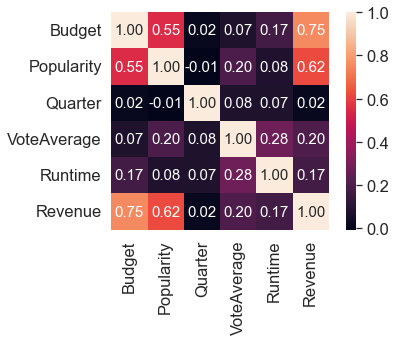

In [286]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

cm = np.corrcoef(HMMovies.values, rowvar=0)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
    annot_kws={'size': 15},
    yticklabels=LRcols,
    xticklabels=LRcols)
plt.show()

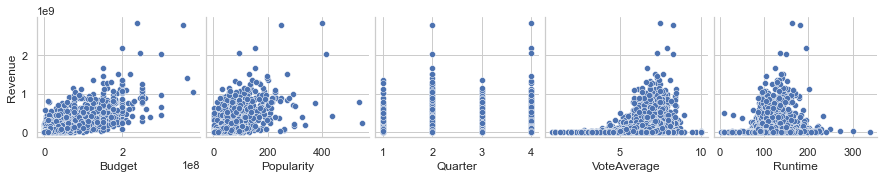

In [287]:
sns.set(style='whitegrid', context='notebook')
sns.pairplot(LRMovies[((LRMovies['Revenue']/LRMovies['Budget']) < 4000) & (LRMovies['Popularity'] < 1000)], x_vars=['Budget', 'Popularity', 'Quarter', 'VoteAverage', 'Runtime'], y_vars=['Revenue'], height=2.5);
plt.show()

As above seen in the heatmap there is a pretty strong correlation between budget and popularity. While the other features perform very poorly. This was to be expected from the analysis done during the [Nearest Neighbor](#Nearest-Neighbor) part. I also chose to add Runtime and VoteAverage to see if these possibly had an unexpected correlaction, but this did not seem to be the case.

I will use sklearn's linear regression using the features Budget and Popularity to predict the target PC (profit correlation).

In [288]:
# Remove NANs from the features that will be selected
LRMovies = LRMovies.drop(LRMovies[LRMovies['Budget'].isnull()].index)
LRMovies = LRMovies.drop(LRMovies[LRMovies['Popularity'].isnull()].index)
LRMovies = LRMovies.drop(LRMovies[LRMovies['Revenue'].isnull()].index)

In [289]:
# Selecting Features
X = LRMovies[['Budget', 'Popularity']].values
y = LRMovies['Revenue'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=1
)

In [290]:
from sklearn.linear_model import LinearRegression

# Applying linear regression
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

In [291]:
from sklearn.metrics import r2_score

print('R^2 train: %.3f, test: %.3f' % 
    (r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

R^2 train: 0.626, test: 0.630


As seen here the linear regression model got 0.63 R^2, 
which is not too bad but I expected better (when discussing with my machine learning teacher he also predicted aroun 0.7-0.8 which I was skeptical about).
  
However this does make sense. I am currently only using two features to predict the revenue, and when looking at other sources that attempted a similar prediction such as [this](https://medium.com/analytics-vidhya/how-to-use-machine-learning-approach-to-predict-movie-box-office-revenue-success-e2e688669972) guide (using sklearn and a similar dataset but more features), you can see that the performance from the basic linear regression model is very similar.

C:\Programs\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


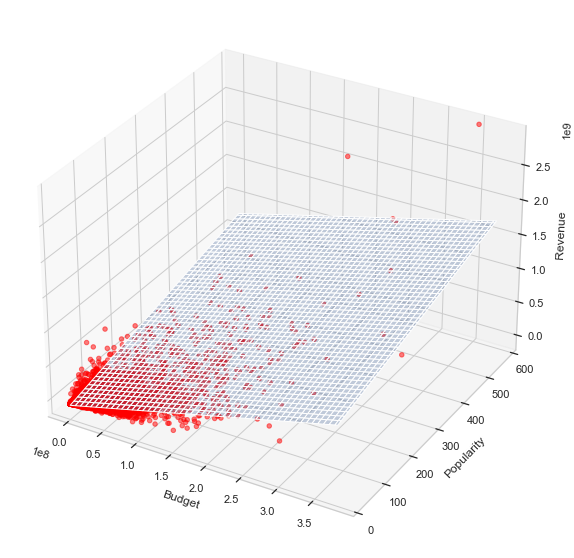

C:\Programs\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


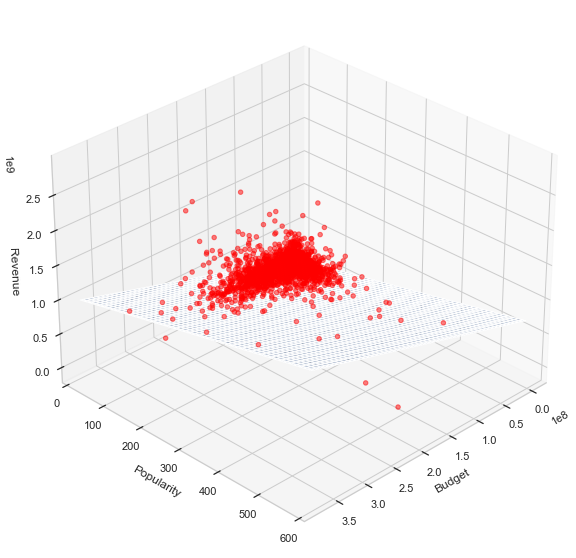

C:\Programs\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


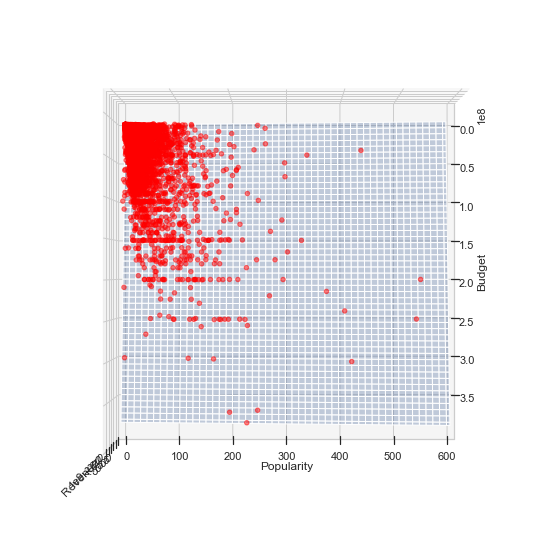

In [292]:
from mpl_toolkits.mplot3d import Axes3D

def RenderSP(elev = 30, rot = -60):
# Get data for rendering 3D plane    
    x_surf, y_surf = np.meshgrid(np.linspace(LRMovies.Budget.min(), LRMovies.Budget.max(), 100),np.linspace(LRMovies.Popularity.min(), 590, 100))
    onlyX = pd.DataFrame({'Budget': x_surf.ravel(), 'Popularity': y_surf.ravel()})
    fittedY=slr.predict(onlyX)
    fittedY=np.array(fittedY)
    
# Create figure
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    
# Populate with datapoints and plane
    ax.scatter(LRMovies['Budget'],LRMovies['Popularity'],LRMovies['Revenue'],c='red', marker='o', alpha=0.5)
    ax.plot_surface(x_surf,y_surf,fittedY.reshape(x_surf.shape), color='b', alpha=0.3)

# Set labels
    ax.set_xlabel('Budget')
    ax.set_ylabel('Popularity')
    ax.set_zlabel('Revenue')

    ax.set_ylim(0, 600)
    
# Rotate figure in 3D space
    ax.view_init(elev, rot)
    plt.show()
RenderSP()
RenderSP(30, 45)
RenderSP(90, 0)


When rendering the 3D plot I noticed that the whole plot is skewed because of one outlier on the Popularity axis, so I filtered this one out for the rendering  
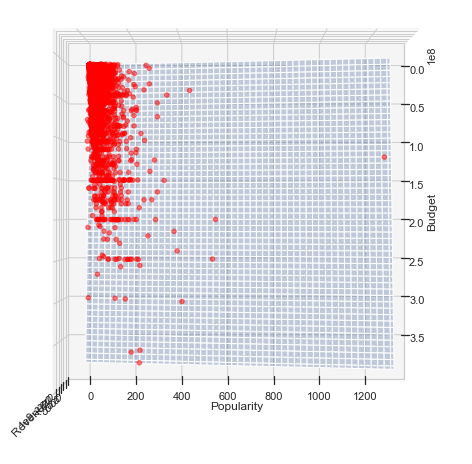  
  
When observing the scatterplots with the linear regression plane, I can see that the datapoints are very clumped up in the corner with low popularity and low budget, this would make predicting across a line a lot harder, it is also very visible that most if not all datapoints are above the plane.

#### Ransac

In [293]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(
    max_trials=20,
    min_samples=500,
    loss='absolute_error',                     
    #residual_metric=lambda x: np.sum(np.abs(x), axis=1), 
    residual_threshold=100000, 
    random_state=0)
ransac.fit(X_train, y_train)
y_train_pred = ransac.predict(X_train)
y_test_pred = ransac.predict(X_test)

inlier_mask = ransac.inlier_mask_
print('Inliers:', inlier_mask.sum())
print('Outliers:', np.logical_not(inlier_mask).sum())

Inliers: 83
Outliers: 5566


In [294]:
from sklearn.metrics import r2_score

print('R^2 train: %.3f, test: %.3f' % 
    (r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

R^2 train: 0.558, test: 0.558


I also tried to use RANSAC to see if this would give me a better result, however when looking at the amount of inliers found, and the large amount of reidual_threshold or min_samples that is needed to create even a reasonable amount, it is clear that using a method like this would not be optimal.

## Evaluation

With this data there does seem to be possibility with these features, more specifically with the Budget and Popularity.  
  
However I do think that the current performance is not great and will have to be improved with more features, luckily as alluded to during the [Data Sourcing](#Data-Sourcing) part, The current dataset is not complete there are more features that can be found to enrich the dataset and the size of the dataset is also only 50% of the total size from TMDB's database.  
  
I also tried looking for other sources to compare my results with, seen as I currently have not gotten the opportunity to talk with an expert in this domain.  
One of these sources that I found was a guide on "[using machine learning to predict movie box office revenue success](https://medium.com/analytics-vidhya/how-to-use-machine-learning-approach-to-predict-movie-box-office-revenue-success-e2e688669972)" from medium.com.  
This guide and a few other bits of information that I found on predicting movie earnings showed me that, while there are many factors at play such as: Actors, marketing, other world events, etc. there is still a large and useful amount of data available for movies that can be used to predict, or atleast make a suggestion on how a movie will perform.